# ULTIMO tutorial: Create an international network 

For the international assignment, it is important to connect the created networks at the border. This will be done using the `CombineNetworks` class in the network module.

First, all country networks are combined to a single GeoDataFrame. It is possible to further filter the road network to minimize file size. After connecting the network at the land borders, it is also possible to include connections over water (ferries or bridges) with the `Ferries` method.

The inputs are:
- Road networks with edges and nodes (see tutorial1)
- TAZ as GeoDataFrame

## Import packages

In [1]:
# for network creation
from ultimo import CreateNetwork

In [2]:
# for reading and saving files etc.
import geopandas as gpd
import pandas as pd
# for time tracking
from datetime import datetime

## Read input: TAZ and networks

The input includes georeferenced TAZ in `EPSG:4326` with the following _required_ attributes (columns):

* __ID__ | field including a unique ID, e.g. the NUTS ID
* __Country__ | field containing the ISO-2 code of the respective country

Other attributes like name, population etc. can be added, but are not required for the following steps.

The network nodes and edges per country, as created in `tutorial1`, are imported and combined to

* __network__ single `GeoDataFrame` with all network edges
* __nodes__ single `GeoDataFrame` with all network nodes

Each edge and node has information on their respective country, which is added during the import process.

In [3]:
# load taz from database or local
taz = gpd.GeoDataFrame.from_file('tutorial-files/_input/taz-tutorial.gpkg')

# defining ID, country and geometry column names of taz
taz_id = "nuts_id"
taz_cn = "cntr_code"
taz_geo = "geometry"

taz.head()

,nuts_id,cntr_code,nuts_name,geometry
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63..."
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62..."
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62..."
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61..."
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62..."


In [4]:
countries = taz[taz_cn].unique()

In [5]:
path_export = 'tutorial-files/tutorial3/'
path_import = 'tutorial-files/tutorial1/'

Read all country networks and nodes and combine them to single GDFs

In [6]:
# get unconnected road network
print('Start combining networks at {}'.format(datetime.now()))
for i, cn in enumerate(countries):
    print("load network... {}".format(cn))
    net = gpd.GeoDataFrame.from_file(path_import +'{}_e'.format(cn)+'.gpkg')
    net['cn'] = cn
    nodes = gpd.GeoDataFrame.from_file(path_import +'{}_n'.format(cn)+'.gpkg')
    nodes['cn'] = cn
    if i == 0:
        net_int = net.copy()
        nodes_int = nodes.copy()
    else:
        net_int = pd.concat([net_int, net])
        nodes_int = pd.concat([nodes_int, nodes])
    del net, nodes
net_int.crs = 4326
nodes_int.crs = 4326
print('Finished at {}'.format(datetime.now()))

Start combining networks at 2023-03-14 17:01:34.265483
load network... FI
load network... DK
load network... SE
load network... NO
Finished at 2023-03-14 17:01:52.847471


## International network

The combined network edges and nodes are used for the `CreateNetwork.CombineNetworks` method. The TAZ data is applied to determine country borders.

Connect border roads

In [7]:
# connect country networks
print('Start connecting networks at {}'.format(datetime.now()))
connect = CreateNetwork.CombineNetworks(taz, net_int)
connect.find_borders(taz_geo=taz_geo)
connect.get_border_roads()
connect.connect_border_roads(nodes_int, filter_types=[1,2,3,8,9])
print('Finished at {}'.format(datetime.now()))

Start connecting networks at 2023-03-14 17:01:52.865585
Start connecting border roads at 2023-03-14 17:02:30.438706
Finished connecting border roads at 2023-03-14 17:02:30.905364
Finished at 2023-03-14 17:02:30.905364


## Add ferries and bridges

If there are islands and countries with no land border in the regarded region, it is possible to extract ferry routes and bridges with ULTIMO and create direct line connections between start and end points. Since the area from which these geometries are extracted is quite large, this process might take multiple hours.

Extract ferries and bridges to include border connections over water

In [ ]:
# Connections over water body (ferries and bridges)
# create routes -- retracting from overpass takes multiple hours
ferry_int = CreateNetwork.Ferries(taz)
print("Extracting ferry routes... {}".format(datetime.now()))
ferry_int.find_ferry_routes()
print("Transforming ferry routes... {}".format(datetime.now()))
ferry_routes, ferry_nodes = ferry_int.ferry_international()

In [17]:
# connect with road network
print("Connect ferry routes to network... {}".format(datetime.now()))
network_w_ferry = ferry_int.ferry_to_road(ferry_routes, ferry_nodes, connect.network_int[connect.network_int.columns[:-1]], nodes_int, ferry_buffer_m=5000)
print("Finished process at {}".format(datetime.now()))

Connect ferry routes to network... 2023-03-15 09:36:02.615009
no start / end connection for ferry route 65
no start / end connection for ferry route 66
Finished process at 2023-03-15 09:36:07.940522


## Save result after tutorial3

In [19]:
# save
network_w_ferry.to_file(path_export + 'international-edges' + '.gpkg', driver='GPKG')

## Result after tutorial3

<AxesSubplot:>

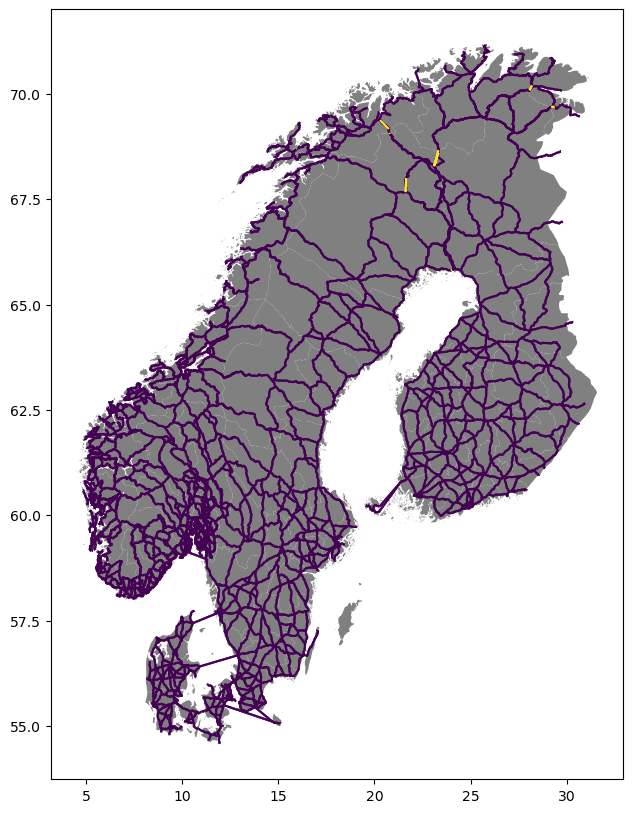

In [20]:
# plot TAZ and roads
ax=taz[taz_geo].plot(color="grey", figsize=(20,10))
network_w_ferry.plot(ax=ax, column='type', kind='geo')